# BERT Bidirectional Encoder Representations from Transformers

Short Intro to transformers: 
source: https://www.youtube.com/watch?v=SZorAJ4I-sA&ab_channel=GoogleCloudTech
Transformer:
- Type of neural network architecture
- NN is effective in analyzing complex data like images, video, text
- Different types of NN:
    - CNN for images, ..
    - RNN used for text -> but
        - works sequentially the computation could not be parallelized
        - not good for long text - it forgets the beginning when it tries to analyze the end
- Tranformers developed by Google 2017 for translation
    - computation parallelized - big models can be trained
- How does it work:
    - Positional Encoding: Storing the word order in the data itself, in form of numbers
        - After training it learns how to interpret the positional encodings
    - Attention: Aligning words between languages?
    - Self-Attention: understanding the context by looking at surrounding words

source: https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

- Bidirectional - you’ll have to look at the previous words and at the next words
- Transformers 
    - Attention mechanism allows for learning contextual relations between words: decrypt his,I,your in a sentence
    - Transformer reads entire sequences of tokens at once: non directional compared to LSTMs sequential approach
- Pre-trained - Contextualized word embeddings
    - Encode words based on their meaning/context: Nails -> Fingernails vs Metal nails

Note: 
- Masked LM (MLM) is used: 
    - During the training of BERT - 15% of the words were masked, it tried to guess these words 
    - It uses the full context of the sentece: both left and right surroundings 
- Trained using Tensorflow
- Semi-Supervised Learning lead to a better performance

Concept:
- BERT relies on a Transformer: the attention mechanism that learns contextual relationships between words in a text
- Transformer consists of:
    - Encoder to read the text input
    - Decoder to produce a prediction
- BERT only needs the encoding part: It's goal is to generate a language representation model

# Hands on
source: https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

In [1]:
# This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2
# !pip install pytorch-pretrained-bert pytorch-nlp

In [2]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-10-02 11:36:33.586018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 11:36:51.882329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv("./data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
display("df shape: ",df.shape)
display("df: ",df.sample(10))

'df shape: '

(8551, 4)

'df: '

,sentence_source,label,label_notes,sentence
985,bc01,0,*,The ship sank to collect the insurance.
6004,c_13,0,*,I want to should eat plums.
2781,l-93,0,*,The ball tossed.
6635,m_02,1,NaN,Maisie drove her car on Wednesday from Morning...
5542,b_73,1,NaN,"I'm sad, as much as I'm angry."
303,cj99,0,??,This is a problem that you'll be able to tell ...
5617,c_13,0,*,Bunnies carrots eat.
6392,d_98,1,NaN,A man who saw the fly in the food didn't eat d...
1313,r-67,1,NaN,When did you get back and what did you bring me?
5459,b_73,0,*,John is a no more reliable fellow than Bill.


In [4]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# text into tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenized first sentence: ", tokenized_texts[0])

Tokenized first sentence:  ['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [5]:
# BERT requires specifically formatted inputs

# 1. input ids: integers identifying each input token to its index number in the BERT tokenizer vocabulary

# 2. segment mask: 1/0 for whether the input is one or two sentences

# 3. attentions mask:  1/0 -> 1: intput tokens , 0: for all pading tokens
    # padding: BERT input should be same length, shorter sentences are filled with 0 to match the max sentence length
    # truncating: defnining max length can lead also that some sentences should be cut

# 4. labels: 1/0 grammatical vs ungrammatical

In [6]:
# Preparing Input Data for BERT

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# 1. Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 3. 

# Pad our input tokens 
max_length = 128
input_ids = pad_sequences(input_ids,maxlen=max_length,dtype="long",padding="post",truncating="post")

# attention mask - 1: intput tokens , 0: for all pading tokens
attention_mask = [] 
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_mask.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_input, test_input, train_labels, test_labels = train_test_split(input_ids,labels, random_state=2023,test_size=0.1)
train_mask, test_mask, _,_ = train_test_split(attention_mask,input_ids,random_state=2023,test_size=0.1)

# Converting data to torch tensors for the model
train_input = torch.tensor(train_input)
test_input = torch.tensor(test_input)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)

# Batch size of 32 is recommended for fine tuning BERT to a specific task
batch_size = 16

# Create an iterator of our data with torch DataLoader. 
# This helps save on memory during training because, unlike a for loop
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_input,train_mask,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data = TensorDataset(test_input,test_mask,test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,sampler = test_sampler, batch_size = batch_size)

In [7]:
# Training loop:
# - Compute gradients by setting the model in train mode 
# - Unpack the data inputs and labels
# - Load data onto the GPU for acceleration
# - Clear out the gradients calculated in the previous pass: In pytorch the gradients accumulate by default unless cleared
# - Forward pass -> feeding input data through the network
# - Backward pass -> backpropagation
# - Updating Parameters with optimizer.step()
# - Track variables for monitoring progress

# Evaluation loop:
# - Don't compute gradients - set the model in evaluation mode
# - Unpack data inputs and labels 
# - Load data onto the GPU for acceleration
# - Forward pass
# - Compute loss on the validation set and track variables

In [8]:
# Training

# 1. BertForSequenceClassification: Modified BERT for classification outputs - BERTopic is way better
# We are going to use already trained layers,
# as expected each pretrained layers can be retrained, frozen, apply different learning rated 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
# Batch size: 16, 32 Learning rate (Adam): 5e-5, 3e-5, 2e-5 Number of epochs: 2, 3, 4

param_optimizer = list(model.named_parameters()) # Extract the parameters (weights and biases) from a PyTorch model
no_decay = ['bias','gamma','beta']

# I have to check how this exaclty works
optimizer_grouped_parameters = [{'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate':0.01},
                                {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate':0.0}]
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [9]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
# Check if a GPU is available and set the device accordingly
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in test_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/home/pclinux/spiced/data_science/capstone_project/convergence_oracle/.venv/lib/python3.10/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6421615481376648
Train loss: 0.6117042005062103
Train loss: 0.5956174532572428
Train loss: 0.5957491099834442
Train loss: 0.6080631256103516
Train loss: 0.6315973699092865
Train loss: 0.5899568966456822
Train loss: 0.5967075675725937
Train loss: 0.5933868024084303
Train loss: 0.5970808207988739
Train loss: 0.606640403920954
Train loss: 0.6094238509734472
Train loss: 0.6096420975831839
Train loss: 0.6104711847645896
Train loss: 0.6120246807734172
Train loss: 0.6024162247776985
Train loss: 0.6074072122573853
Train loss: 0.6151974962817298
Train loss: 0.6168198460026791
Train loss: 0.6234326124191284
Train loss: 0.6160168676149278
Train loss: 0.6150909933176908
Train loss: 0.6126759544662808
Train loss: 0.6111100887258848
Train loss: 0.6130145621299744
Train loss: 0.6135668112681463
Train loss: 0.6146010337052522
Train loss: 0.6136574085269656
Train loss: 0.613637665222431
Train loss: 0.6132960895697276
Train loss: 0.6181305646896362
Train loss: 0.6213891822844744
Train loss

Epoch:  50%|█████     | 1/2 [1:03:35<1:03:35, 3815.23s/it]

Validation Accuracy: 0.8055555555555556
Train loss: 0.23362430930137634
Train loss: 0.2838973104953766
Train loss: 0.27266379197438556
Train loss: 0.3257574439048767
Train loss: 0.31362542510032654
Train loss: 0.3061577280362447
Train loss: 0.30250110796519686
Train loss: 0.29173095896840096
Train loss: 0.2746096799770991
Train loss: 0.2587835744023323
Train loss: 0.2573838220401244
Train loss: 0.2526530288159847
Train loss: 0.2396189644932747
Train loss: 0.2527533072446074
Train loss: 0.2548566127816836
Train loss: 0.2708711908198893
Train loss: 0.2585255006218658
Train loss: 0.2528752562486463
Train loss: 0.2456003202027396
Train loss: 0.23528474010527134
Train loss: 0.23868281819990703
Train loss: 0.24974835088307207
Train loss: 0.26536296405222104
Train loss: 0.25794048979878426
Train loss: 0.2564080959558487
Train loss: 0.25516948046592564
Train loss: 0.25666798099323557
Train loss: 0.25824487688285963
Train loss: 0.25688614721955927
Train loss: 0.25477199057737987
Train loss: 0.2

Epoch: 100%|██████████| 2/2 [2:07:48<00:00, 3834.27s/it]  

Validation Accuracy: 0.8310185185185185


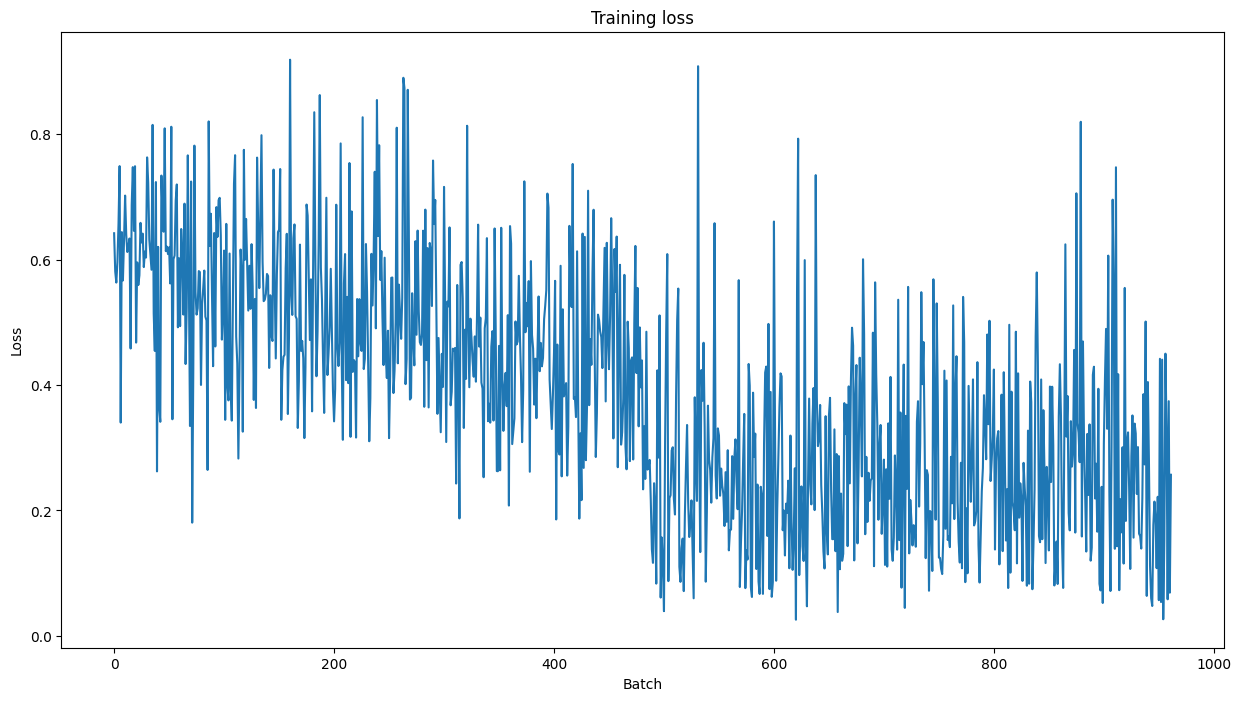

In [12]:
# Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
# Predict and Evaluate on Holdout Set
df = pd.read_csv("./data/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [13]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [14]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
 # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [15]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

: 

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()
optimizer.zero_grad()

In [ ]:
# Importing science journals between 1880 - 2023
from custom_functions import cf_clustering as cfc
# This is required when you're using jupyter notebook and want to make changes to your custom function
import importlib
importlib.reload(cfc)

file_path = "./data/1880-2023_Science_48966.csv"
input_column_name = "title_abstract"

columns_to_drop = [
    'paperId', 's2FieldsOfStudy', 'MAG', 'DOI', 'CorpusId',
    'ArXiv', 'DBLP', 'PubMed', 'PubMedCentral', 'id', 'issn',
    'alternate_issns', 'alternate_urls', 'type', 'publicationTypes', 'url'
]

# Loading the data set without removing stop words - the results are better
print("Step 1/7: Loading the dataset ...")
df_publications = cfc.load_csv_file_to_df_publications(file_path)
print("Step 2/7: Cleaning the dataset ...")
df_publications = cfc.clean_dataset(df_publications)
print("Step 3/7: Creating the analysis column ...")
df_publications = cfc.combine_columns(df_publications,"title","abstract",input_column_name)
df_publications.shape
df_publications['title_abstract'].sample(5)
print("df_publications shape: ",df_publications.shape)
print("df_publications: ",df_publications.sample(10))

In [ ]:
# Notes:
# video about training and validation loss: https://www.youtube.com/watch?v=p3CcfIjycBA&ab_channel=DigitalSreeni